<a href="https://colab.research.google.com/github/abenstirling/sdxai_hackathon/blob/main/GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!rm -rf sdxai_hackathon
!git clone "https://github.com/abenstirling/sdxai_hackathon.git"

Cloning into 'sdxai_hackathon'...
remote: Enumerating objects: 17754, done.
remote: Counting objects: 100% (4480/4480), done.
remote: Compressing objects: 100% (2134/2134), done.
remote: Total 17754 (delta 2377), reused 4441 (delta 2346), pack-reused 13274
Receiving objects: 100% (17754/17754), 57.24 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (9188/9188), done.


In [4]:
!cd sdxai_hackathon; git pull

Already up to date.


In [5]:
## get data into the model (serial)


n_samples = 1024

X = np.empty((0,n_samples))
y = np.empty((0,3,3,2))

folder_path = '/Xy'
files = os.listdir('sdxai_hackathon/Xy')
num_files = len(files)
print(f"Num files: {num_files}")

for i in range(2000):
  fX = f'sdxai_hackathon/Xy/{i}X.pkl'
  fy = f'sdxai_hackathon/Xy/{i}y.pkl'
  if os.path.exists(fX) and os.path.exists(fy):

    with open(fy,'rb') as f:
      RCL = np.array(pickle.load(f))
      RCL = np.reshape(RCL, (1,3,3,2))
      # print(RCL.shape)
      # print(y.shape)
      y = np.append(y, RCL, axis=0)
    with open(fX,'rb') as f:
      samples = np.array(pickle.load(f))
      samples = np.reshape(samples, (1, n_samples))
      X = np.append(X, samples, axis=0)

print(X[0])
print(y[0])

print(X.shape)



Num files: 2298
[0.         0.68661337 0.68614857 ... 0.52397518 0.52394481 0.52391452]
[[[-0.          0.5       ]
  [ 0.75683008  0.05653292]
  [ 0.89169654  0.05600491]]

 [[-0.          0.5       ]
  [-0.          0.5       ]
  [ 0.77784866  0.21698487]]

 [[-0.          0.5       ]
  [-0.          0.5       ]
  [-0.          0.5       ]]]
(1149, 1024)


In [6]:
X = torch.tensor(X,dtype=torch.float)
y = torch.tensor(y,dtype=torch.float)
print(X.dtype,y.dtype)

X = torch.unsqueeze(X,dim=1)
print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


torch.float32 torch.float32
torch.Size([1149, 1, 1024]) torch.Size([1149, 3, 3, 2])


In [7]:
len(X_train), len(X_test)

(919, 230)

In [8]:
len(y_train), len(y_test)

(919, 230)

In [9]:
X_train[0]

tensor([[0.0000, 0.0013, 0.0038,  ..., 0.9248, 0.9250, 0.9252]])

torch.Size([919, 3, 3, 2])


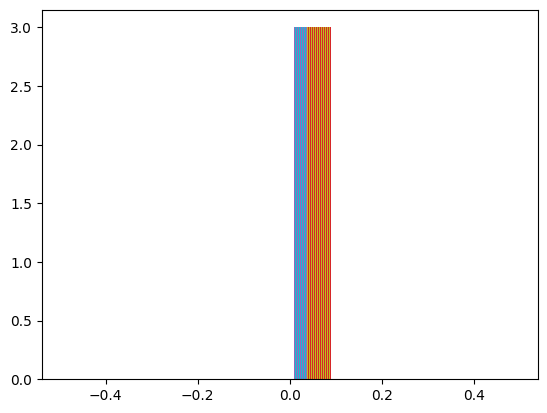

In [10]:
y_train[0]
plt.hist(y_train[:,:,0,0].cpu(), label="real")

print(y_train.shape)



In [11]:
class MyModel(nn.Module):
    def __init__(self, n, sample_dim, c1_dim, c2_dim, c3_dim, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c1_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=c1_dim, out_channels=c2_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=c2_dim, out_channels=c3_dim, kernel_size=9, padding=4)
        self.rnn = nn.RNN(input_size=c3_dim * sample_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n*n*2)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

        self.norm1 = nn.BatchNorm1d(num_features=c1_dim)
        self.norm2 = nn.BatchNorm1d(num_features=c2_dim)
        self.norm3 = nn.BatchNorm1d(num_features=c3_dim)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.relu(self.conv2(x))
        x = self.norm2(x)
        x = self.relu(self.conv3(x))
        x = self.norm3(x)

        x = x.view(x.size(0), -1)

        output, _ = self.rnn(x)
        output = output[:, -1]

        output = self.relu(self.fc1(output))
        output = self.relu(self.fc2(output))
        output = self.softmax(self.fc3(output))

        return output.view(output.size(0), n, n, 2)

n = 4
sample_dim = 1024
c1_dim = 64
c2_dim = 128
c3_dim = 128
hidden_size = 64
num_layers = 1
output_size = (n*n*2)

model_1 = MyModel(n, sample_dim, c1_dim, c2_dim, c3_dim, hidden_size, num_layers, output_size).to(device)

In [86]:
class GG(nn.Module):
  def __init__(self, n, sample_dim, c1_dim, c2_dim, c3_dim):
    super().__init__()

    self.C_1 = nn.Conv1d(in_channels=1,
                    out_channels=c1_dim,
                    kernel_size=3,
                    padding=1)
    self.C_2 = nn.Conv1d(in_channels=c1_dim,
                    out_channels=c2_dim,
                    kernel_size=3,
                    padding=1)
    self.C_3 = nn.Conv1d(in_channels=c2_dim,
                    out_channels=c3_dim,
                    kernel_size=3,
                    padding=1)
    self.L_1 = nn.Linear(in_features=c3_dim * sample_dim, out_features=128)
    self.L_2 = nn.Linear(in_features=128, out_features=128)
    self.L_3 = nn.Linear(in_features=128, out_features=(n*n*2))

    self.relu = nn.ReLU()

    self.norm1 = nn.BatchNorm1d(num_features=c1_dim)
    self.norm2 = nn.BatchNorm1d(num_features=c2_dim)
    self.norm3 = nn.BatchNorm1d(num_features=c3_dim)


  def forward(self, x):

    x = self.relu(self.C_1(x))
    #print(x.shape)
    x = self.norm1(x)
    #print(x.shape)
    x = self.relu(self.C_2(x))
    x = self.norm2(x)
    x = self.relu(self.C_3(x))
    x = self.norm3(x)

    #print(x.shape)
    # print(x.size(0))
    # print(f"After c1d: {x.shape}")
    x = x.view(x.size(0), -1)
    #print(f"After view: {x.shape}")


    x = self.relu(self.L_1(x))
    x = self.relu(self.L_2(x))
    x = self.L_3(x)

    return x.view(x.size(0),n,n,2)


n = 3
sample_dim = 1024
c1_dim = 64
c2_dim = 64
c3_dim = (n*n*2)

model_0 = GG(n, sample_dim, c1_dim, c2_dim, c3_dim).to(device)

In [87]:
#optuna

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                             lr=.01)

# ---------------------------------------------------------------------------
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# ---------------------------------------------------------------------------

torch.manual_seed(0)
torch.cuda.manual_seed(0)

loss_vals=[]
test_loss_vals=[]
epoch_vals=[]

epochs = 100
batch_size = 32

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
  for batch in dataloader:
    X_batch, y_batch = batch

    model_0.train()
    y_preds = model_0(X_batch)
    # print(f"y_preds shape: {y_preds.shape}")
    # print(f"y_batch shape: {y_batch.shape}")
    loss = loss_fn(y_preds, y_batch)
    #acc = accuracy_fn
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():


      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred,y_test)
      #test_acc = accuracy_fn(y_true=, y_pred=)

  if epoch % 1 == 0:
    epoch_vals.append(epoch)
    loss_vals.append(loss)
    test_loss_vals.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} |Test loss: {test_loss}")

Epoch: 0 | Loss: 0.05216280370950699 |Test loss: 0.10879233479499817
Epoch: 1 | Loss: 0.04543815180659294 |Test loss: 0.03930265083909035
Epoch: 2 | Loss: 0.04935963824391365 |Test loss: 0.03663884103298187
Epoch: 3 | Loss: 0.035456929355859756 |Test loss: 0.0342823788523674
Epoch: 4 | Loss: 0.03964045271277428 |Test loss: 0.03353387489914894
Epoch: 5 | Loss: 0.027845017611980438 |Test loss: 0.03273346275091171
Epoch: 6 | Loss: 0.03285887837409973 |Test loss: 0.03226166218519211
Epoch: 7 | Loss: 0.03533163666725159 |Test loss: 0.03234167397022247
Epoch: 8 | Loss: 0.03454487398266792 |Test loss: 0.031049275770783424
Epoch: 9 | Loss: 0.02814483642578125 |Test loss: 0.0304742269217968
Epoch: 10 | Loss: 0.028494730591773987 |Test loss: 0.030663860961794853
Epoch: 11 | Loss: 0.02796412631869316 |Test loss: 0.03010677732527256
Epoch: 12 | Loss: 0.03205365687608719 |Test loss: 0.029358815401792526
Epoch: 13 | Loss: 0.033935513347387314 |Test loss: 0.03042091242969036
Epoch: 14 | Loss: 0.02554

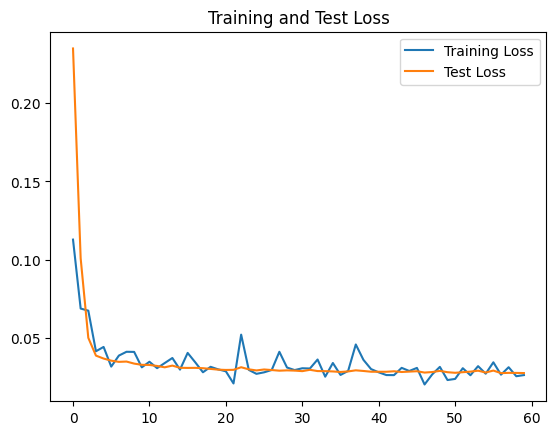

In [78]:


epoch_vals = np.array(epoch_vals)
loss_vals = np.array([loss.item() for loss in loss_vals])
test_loss_vals = np.array([test_loss.item() for test_loss in test_loss_vals])


plt.plot(epoch_vals, loss_vals, label="Training Loss")
plt.plot(epoch_vals, test_loss_vals, label="Test Loss")
plt.title("Training and Test Loss")
plt.legend()

C12 N1 N2 6.789418334960937e-07 0 
V1 N1 0 step 1

.
R12 N1 N2 566.3350830078125
L12 N1 N2 8.694041442871095e-08 0 
R13 N1 0 674.3203735351562
L13 N1 0 2.240681304931641e-07 0 
R23 N2 0 788.8507080078125
L23 N2 0 9.578204956054688e-07 0 
V1 N1 0 step 1

.


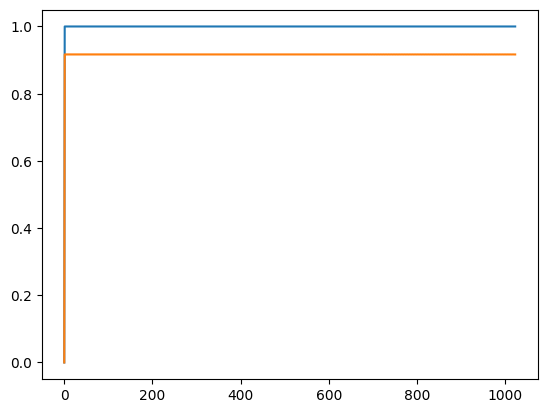

R12 N1 N2 8.317666053771973
L12 N1 N2 8.830994262695313e-07 0 
R13 N1 0 378.0267028808594
L13 N1 0 6.400736083984375e-07 0 
V1 N1 0 step 1

.
R12 N1 N2 566.3350830078125
L12 N1 N2 8.694041442871095e-08 0 
R13 N1 0 674.3203735351562
L13 N1 0 2.240681304931641e-07 0 
R23 N2 0 788.8507080078125
L23 N2 0 9.578204956054688e-07 0 
V1 N1 0 step 1

.


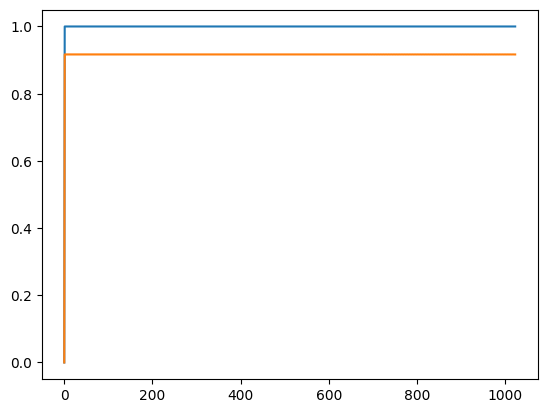

L12 N1 N2 6.964937744140625e-07 0 
R23 N2 0 914.498291015625
C23 N2 0 4.9525830078125e-07 0 
V1 N1 0 step 1

.
R12 N1 N2 596.3798828125
L12 N1 N2 3.8580023193359375e-07 0 
R13 N1 0 641.8085327148438
C13 N1 0 5.559508895874024e-08 0 
R23 N2 0 468.18634033203125
C23 N2 0 4.940494995117188e-07 0 
V1 N1 0 step 1

.


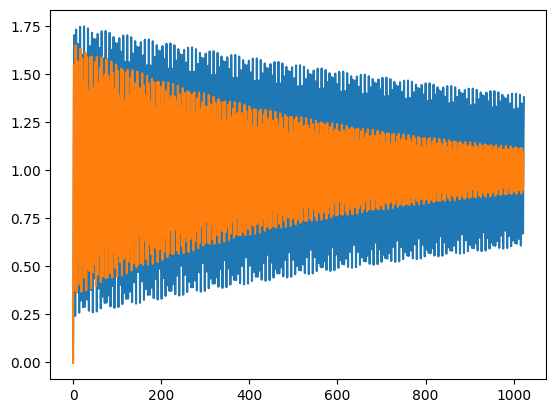

Accuracy given by MAE: 
[0.08313445124563576, 0.08313445124564231, 0.3871333816034762]


In [132]:
def accuracy_fn(y_target,
                y_pred):
  acc = []
  for complex_matrix_target, complex_matrix_pred in zip(y_target.cpu(), y_pred.cpu()):
    component_matrix_target = genComponentMatrix(complex_matrix_target,300)
    component_matrix_pred = genComponentMatrix(complex_matrix_pred,300)

    sig_response_target = simulateCircuitMatrix(componentMatrix=component_matrix_target,
                                        t_stop=1.023E-3,
                                        dt=1E-6)
    sig_response_pred = simulateCircuitMatrix(componentMatrix=component_matrix_pred,
                                        t_stop=1.023E-3,
                                        dt=1E-6)

    plt.plot(sig_response_target, label="Target")
    plt.plot(sig_response_pred, label="Prediction")
    plt.show()

    absolute_errors = np.abs(sig_response_target - sig_response_pred)
    mae = np.mean(absolute_errors)

    acc.append(mae)
  return acc



model_0.eval()
with torch.inference_mode():
  y_pred = model_0(X_test)

  num_circuits = 3
  y_p = y_pred[24:24+num_circuits]
  y_t = y_test[24:24+num_circuits]



  # print(y_p.shape)
  # print(y_t.shape)

  acc = accuracy_fn(y_t,
                    y_p)
  print(f"Accuracy given by MAE: \n{acc}")


# L = nn.L1Loss()
# L(y_pred, y_test)



In [124]:
!pip install lcapy
import lcapy as lc
import matplotlib.pyplot as plt
import numpy as np



def simulateCircuitMatrix(componentMatrix, t_stop, dt):
    # component matrix is n x n x 3 of [R, C, L]
    # tStop is stop time in seconds
    # sample rate is dt in seconds
    # returns n x 1 array of voltage vs time in response to step function

    netlist = generateNetlistFromCompMatrix(componentMatrix)
    response = simulateStepResponse(netlist, t_stop, dt)

    return response

def genComplexMatrix(componentMatrix,a):
    inSize = np.shape(componentMatrix)
    complexMatrix = np.zeros([inSize[0], inSize[1], 2])
    for row in range(inSize[0]):
        for col in range(inSize[1]):
            complexMatrix[row,col,:] = get2MatrixFromComponent(componentMatrix[row,col,:],a)
    return complexMatrix

def genComponentMatrix(complexMatrix, a=100):
    inSize = np.shape(complexMatrix)
    componentMatrix = np.zeros([inSize[0], inSize[1], 3])
    for row in range(inSize[0]):
        for col in range(inSize[1]):
            componentMatrix[row,col,:] = getComponentFrom2Matrix(complexMatrix[row,col,:],a)
    return componentMatrix


# ---------------------------------------------------------------------------
def getComponentFrom2Matrix(x,a):
    # scaling factor
    if(x[0] == 1):
        R = np.inf
    else:
        temp1 = a*np.log((1+x[0])/(1-x[0]))
        R = temp1
    if(x[1] == 0.5):
        L = 0
        C = 0
    elif(x[1] == 0):
        L = np.inf
        C = 0
    elif(x[1] == 1):
        L = np.inf
        C = 0
    else:
        #print(x[1])
        if not (1-x[1] <= 0):
          temp2 = a*np.log(x[1]/(1-x[1]))
        else:
          temp2 = 0.0
        C = L = 0;
        if(temp2 > 0):
            L = temp2
            C = 0;
        elif(temp2 < 0):
            C = -temp2
            L = np.inf
    return [R, C, L]

def get2MatrixFromComponent(component,a):
    # component is (R,C,L) in units of kOhm, nF, nH
    R = component[0]
    C = component[1]
    L = component[2]
    if(C != 0 and L != np.inf):
        # can't have both L and  C between nodes
        print("Can't have both L and C on the same node!!!")
    if(R == np.inf):
        x1 = 1
    else:
        temp1 = np.exp(-R/a)
        x1 = -(temp1-1)/(temp1+1)
    temp2 = 0
    if(C == 0 and L == np.inf):
        x2 = 1;
    else:
        if(C == 0 and L != np.inf):
            temp2 = L
        elif(C != 0 and L == np.inf):
            temp2 = -C
        x2 = 1/(1+np.exp(-temp2/a))
    return [x1, x2]

def generateNetlistFromCompMatrix(X):
    matrixSize = X.shape
    num_nets = matrixSize[1]
    netlist = ''
    for i in range(num_nets):
        for j in range(i+1,num_nets):
            R = np.real(X[i, j, 0])
            C = np.real(X[i, j, 1])
            L = np.real(X[i, j, 2])
            node1 = f'N{i+1}'
            if(j == num_nets-1):
                node2 = '0'
            else:
                node2 = f'N{j+1}'
            if(C != 0 and L != np.inf):
                print("L and C cannot both be present!")
            if(R != np.inf):
                component_name = f'R{i+1}{j+1}'
                netlist += f"{component_name} {node1} {node2} {R}\n"
            if(C != 0):
                component_name = f'C{i+1}{j+1}'
                netlist += f"{component_name} {node1} {node2} {C*1e-9} 0 \n"
            if(L != np.inf):
                component_name = f'L{i+1}{j+1}'
                netlist += f"{component_name} {node1} {node2} {L*1e-9} 0 \n"

    # add step voltage source
    netlist += f"V1 N1 0 step 1\n"
    #netlist += f"R0 N3 0 0"

    print(netlist)
    print('.')
    return netlist

def simulateStepResponse(netlist, duration=1, time_step = 0.001):
    # Create the circuit from the netlist
    circuit = lc.Circuit(netlist)
    #print(circuit)
    # circuit.draw();
    # Define the step input
    #Vstep = lc.StepVoltageSource('Vstep', initial_value=0, final_value=1, pulse_width=duration)

    # Add the step input to the circuit
    #circuit.add_source(Vstep)

    # Set the end time and number of points for simulation
    # circuit.draw()
    #circuit.set_end_time(duration)
    num_points = duration/time_step + 1;
    #circuit.set_num_samples(num_points)
    timeEval = np.linspace(0, duration, round(num_points))

    # Perform the simulation
    response = circuit.sim(timeEval)  # 'N' refers to the node name

    return response.N2.v
# ---------------------------------------------------------------------------

